# Reducción de dimensión y clasificación en el dataset USPS

En este cuaderno exploraremos el efecto de distintas técnicas de reducción de dimensión —específicamente **PCA** y **UMAP**— sobre la base de datos **USPS** de dígitos manuscritos. Analizaremos cómo estas proyecciones capturan la estructura del espacio de entrada y cómo afectan el rendimiento de clasificadores.

El flujo general será el siguiente:

1. **Carga y preprocesamiento del dataset USPS**
2. **Reducción de dimensión con PCA y UMAP**
3. **Visualización de los espacios proyectados**, coloreando por clase e incluyendo imágenes representativas
4. **Clasificación en los espacios reducidos** usando tres modelos, incluyendo uno basado en aprendizaje profundo
5. **Análisis de resultados y visualización de métricas** (matrices de confusión, curvas ROC, etc.)

Este enfoque nos permitirá entender la relación entre técnicas de reducción de dimensión y la capacidad discriminativa de diferentes clasificadores.


In [ ]:
# Comprobamos si estamos usando GPU
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ Usando GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("⚠️ No se detectó GPU, se usará CPU.")

# Instalamos dependencias necesarias
!pip install -q umap-learn scikit-learn matplotlib seaborn datasets torch torchvision

# Imports generales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
from tqdm import tqdm
import random


✅ Usando GPU: NVIDIA L4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.1 MB/s eta 0:00:00


## Carga del dataset USPS

El dataset **USPS** contiene imágenes en escala de grises de dígitos manuscritos (del 0 al 9), en tamaño 16x16 píxeles. Lo descargaremos desde Kaggle usando `kagglehub`, y luego lo cargaremos a memoria para su procesamiento.

Este conjunto de datos es útil para tareas de reducción de dimensión y clasificación, ya que presenta una estructura de clases relativamente clara, pero también ambigüedad visual suficiente para evaluar cómo los métodos de reducción preservan la separabilidad de clases.


In [ ]:
# Instalamos kagglehub si no está instalado
!pip install -q kagglehub

import kagglehub
import os

# Descargamos el dataset
path = kagglehub.dataset_download("bistaumanga/usps-dataset")
print("📁 Dataset descargado en:", path)

# Exploramos qué contiene
print("\nArchivos disponibles:")
print(os.listdir(path))

100%|██████████| 2.75M/2.75M [00:01<00:00, 2.34MB/s]

Extracting files...
📁 Dataset descargado en: /root/.cache/kagglehub/datasets/bistaumanga/usps-dataset/versions/1

Archivos disponibles:
['usps.h5']


In [ ]:
import h5py

# Ruta al archivo h5
h5_path = os.path.join(path, "usps.h5")

# Abrimos el archivo
with h5py.File(h5_path, "r") as f:
    print("🔍 Claves del archivo HDF5:")
    print(list(f.keys()))

    # Cargamos los datasets de entrenamiento y prueba
    X_train = f["train/data"][:]
    y_train = f["train/target"][:]
    X_test = f["test/data"][:]
    y_test = f["test/target"][:]

# Unificamos en un solo conjunto
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

print(f"\n🖼️ Imágenes cargadas: {X.shape[0]} muestras de {X.shape[1]} píxeles (vectorizadas)")
print(f"🔢 Etiquetas cargadas: {y.shape}")

🔍 Claves del archivo HDF5:
['test', 'train']

🖼️ Imágenes cargadas: 9298 muestras de 256 píxeles (vectorizadas)
🔢 Etiquetas cargadas: (9298,)


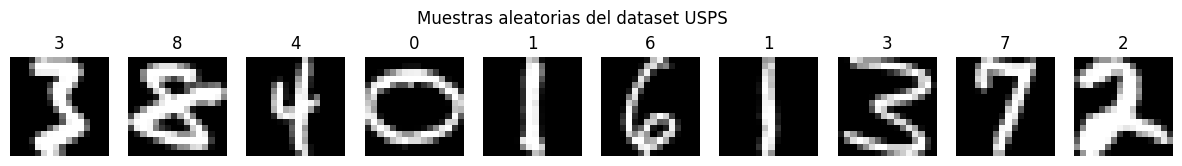

In [ ]:
# Visualizamos 10 imágenes aleatorias del dataset
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    idx = random.randint(0, len(X) - 1)
    img = X[idx].reshape(16, 16)
    label = y[idx]
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(str(label))
    axes[i].axis("off")

plt.suptitle("Muestras aleatorias del dataset USPS")
plt.show()

## Reducción de dimensión

Los conjuntos de datos del mundo real suelen tener una alta dimensionalidad. En el caso del dataset **USPS**, cada imagen de dígito manuscrito está representada como un vector en $\mathbb{R}^{256}$ (16x16 píxeles). Trabajar en espacios tan grandes puede ser problemático por varias razones:

- **Costo computacional**: A mayor número de dimensiones, mayor complejidad en el procesamiento y entrenamiento de modelos.
- **Visualización**: Es imposible visualizar directamente datos en más de 3 dimensiones. Reducir a 2D o 3D permite explorar la estructura del conjunto de datos.
- **Ruido y redundancia**: No todas las dimensiones aportan información útil. Algunas pueden ser ruidosas o estar altamente correlacionadas con otras.
- **"Curse of dimensionality"**: En espacios de alta dimensión, las distancias entre puntos pierden significado, lo que afecta negativamente a algoritmos como k-NN o clustering.

### Objetivo

En esta sección, proyectaremos el dataset USPS a un espacio de menor dimensión utilizando dos métodos complementarios:

- **PCA (Análisis de Componentes Principales)**: una técnica lineal que busca las direcciones de máxima varianza.
- **UMAP (Uniform Manifold Approximation and Projection)**: un método no lineal que intenta preservar la estructura local del espacio original.

Ambos métodos se aplicarán para reducir el espacio de entrada a **2 dimensiones**, permitiendo una visualización directa. También exploraremos cómo se comporta UMAP al modificar su parámetro `n_neighbors`, que controla el equilibrio entre estructura local y global.

Más adelante, entrenaremos clasificadores sobre estas representaciones reducidas y analizaremos su desempeño.


## PCA: Análisis de Componentes Principales

**PCA (Principal Component Analysis)** es un método lineal de reducción de dimensión que busca transformar el espacio original en un nuevo sistema de coordenadas, donde:

- Cada nueva dimensión (componente principal) es una combinación lineal de las dimensiones originales.
- Las componentes están ordenadas según la **varianza** que explican del conjunto de datos.
- Los ejes (componentes) son ortogonales entre sí.

### ¿Por qué varianza?

Intuitivamente, la varianza mide cuánta "información" o "diversidad" hay en una dimensión. PCA busca preservar la mayor cantidad de varianza posible en las primeras dimensiones del nuevo espacio, descartando las direcciones menos informativas.

### Geometría del PCA

Supongamos un conjunto de datos centrado (media cero). PCA resuelve el siguiente problema de optimización:


$\text{Maximizar } \text{Var}(Xw) \quad \text{tal que } \|w\| = 1$

Es decir, encuentra un vector $w$ de norma 1 tal que la proyección de los datos $X$ sobre $w$ tenga la máxima varianza posible.

Esto equivale a encontrar los **autovectores** de la matriz de covarianza $\Sigma = X^T X$, asociados a los mayores **autovalores**. Cada autovector define una componente principal.

### Aplicación práctica

En nuestro caso, reduciremos el dataset de 256 dimensiones a 2 componentes principales. Esto nos permitirá visualizar cómo las clases se separan (o no) en un espacio linealmente proyectado.

Más adelante, compararemos este espacio con el generado por UMAP, que no impone restricciones de linealidad.


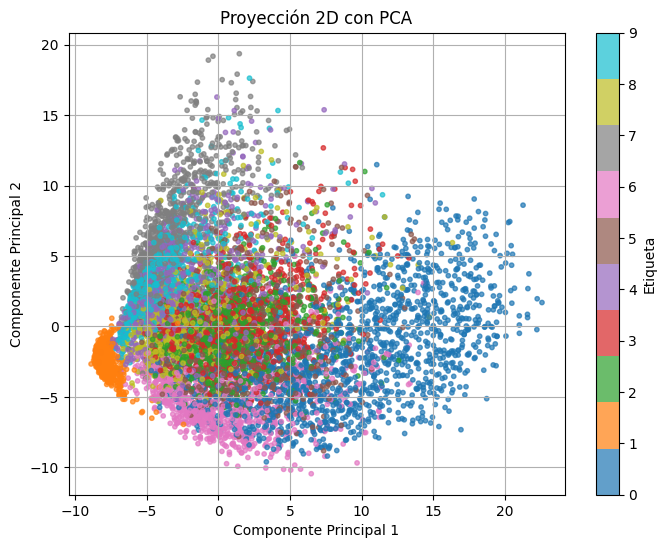

In [ ]:
# Estandarizamos los datos antes de aplicar PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicamos PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización de la proyección PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab10", s=10, alpha=0.7)
plt.title("Proyección 2D con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(scatter, ticks=range(10), label="Etiqueta")
plt.grid(True)
plt.show()

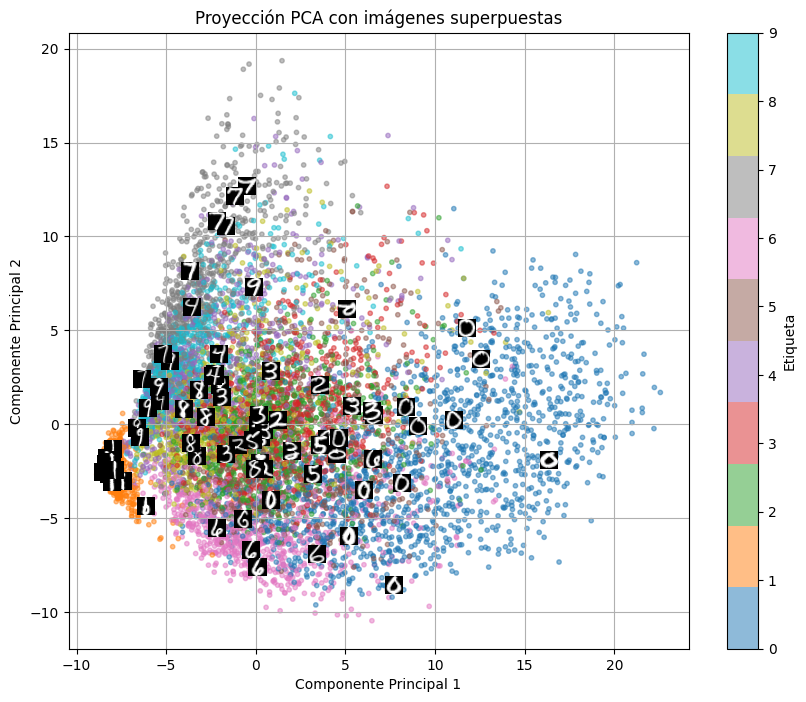

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Cantidad de imágenes a superponer
n_samples = 80
indices = np.random.choice(len(X_pca), n_samples, replace=False)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10, 8))

# Graficamos los puntos coloreados como antes
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab10", s=10, alpha=0.5)

# Superponemos las imágenes seleccionadas
for idx in indices:
    image = X[idx].reshape(16, 16)
    imagebox = OffsetImage(image, cmap="gray", zoom=0.8)
    ab = AnnotationBbox(imagebox, X_pca[idx], frameon=False)
    ax.add_artist(ab)

ax.set_title("Proyección PCA con imágenes superpuestas")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
plt.colorbar(scatter, ticks=range(10), label="Etiqueta")
plt.grid(True)
plt.show()


### Análisis de la proyección PCA

En el gráfico anterior, se observa la proyección del dataset **USPS** a un espacio bidimensional mediante **PCA**, junto con una muestra de imágenes reales superpuestas.

#### Observaciones clave:

- Algunas clases, como los dígitos **0**, **1** y **7**, tienden a formar **agrupaciones distinguibles**, lo cual indica que **PCA captura parcialmente la estructura de clases**.
- Sin embargo, hay un **traslape importante** entre varias clases, en especial los dígitos **3**, **5**, **6** y **8**, que aparecen dispersos por todo el espacio. Esto sugiere que **una proyección lineal no es suficiente para separar adecuadamente todas las clases**.
- La distribución es globalmente alargada en ciertas direcciones, reflejando que **PCA ordena los datos según direcciones de máxima varianza**, pero **no necesariamente de máxima separabilidad de clases**.
- Las imágenes superpuestas permiten confirmar visualmente que regiones locales del espacio tienden a agrupar dígitos similares (e.g., zona inferior derecha dominada por "0").

#### Conclusión

PCA proporciona una representación útil para explorar el dataset y algunas clases se benefician de esta reducción. Sin embargo, su naturaleza **lineal** limita su capacidad para separar clases complejas o no linealmente separables. Esto motiva la exploración de métodos **no lineales** como **UMAP**, que veremos a continuación.


## UMAP: Uniform Manifold Approximation and Projection

**UMAP** es un algoritmo de reducción de dimensión no lineal basado en principios de **teoría de grafos**, **topología algebraica** y **geometría diferencial**. A diferencia de PCA, que es un método lineal global, UMAP busca capturar la **estructura local** de los datos y proyectarla en un espacio de menor dimensión.

### Intuición del método

1. **Construcción de un grafo local**: UMAP construye un grafo ponderado en el espacio de alta dimensión, donde los nodos representan muestras y las aristas conectan vecinos cercanos. La conectividad se basa en distancias entre puntos, moduladas por una función de probabilidad local.
2. **Proyección al espacio reducido**: Luego, UMAP intenta construir un nuevo grafo en el espacio de menor dimensión que **preserve las mismas relaciones de conectividad** entre puntos.
3. **Optimización**: Se minimiza la diferencia entre ambos grafos usando una función de pérdida basada en la divergencia cruzada (similar a t-SNE).

### Parámetros clave

- `n_neighbors`: controla el tamaño del vecindario considerado para construir el grafo local.  
  - Valores **pequeños** preservan más la **estructura local** (subgrupos).  
  - Valores **grandes** tienden a capturar más la **estructura global**.
- `min_dist`: controla qué tan juntas pueden quedar las proyecciones en el nuevo espacio.  
  - Valores **bajos** permiten agrupamientos más compactos.

### Ventajas sobre PCA

- Captura relaciones no lineales entre variables.
- Se adapta mejor a la **forma intrínseca** del conjunto de datos.
- Muy útil para **visualización** y **preprocesamiento** antes de clustering o clasificación.

### Aplicación práctica

Proyectaremos los datos a 2 dimensiones usando UMAP y visualizaremos el resultado. Luego, exploraremos cómo afecta el parámetro `n_neighbors` a la estructura del espacio latente.


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


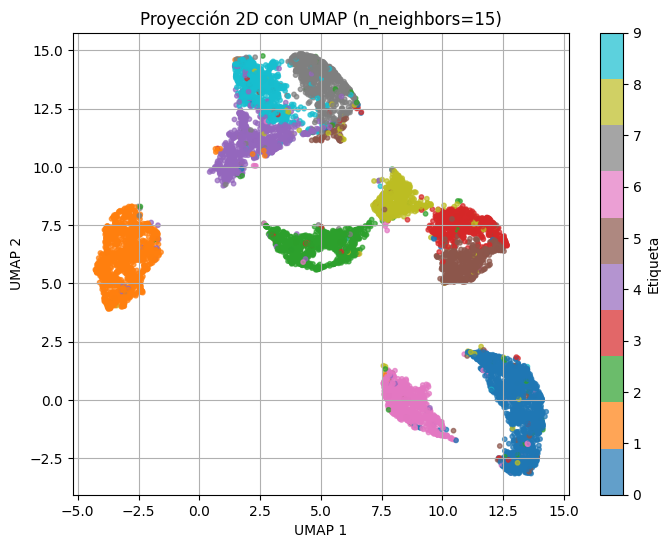

In [ ]:
# UMAP espera entradas flotantes, por seguridad nos aseguramos
X_umap_input = X_scaled  # ya habíamos estandarizado antes

# Aplicamos UMAP a 2 dimensiones
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_umap_input)

# Visualización
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap="tab10", s=10, alpha=0.7)
plt.title("Proyección 2D con UMAP (n_neighbors=15)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=range(10), label="Etiqueta")
plt.grid(True)
plt.show()


### Análisis de la proyección UMAP (n_neighbors = 15)

La proyección obtenida mediante UMAP con `n_neighbors=15` muestra una estructura **mucho más segmentada** que la obtenida con PCA. Algunas observaciones importantes:

- Las clases aparecen **bien separadas en clusters** compactos, lo que sugiere que UMAP logra preservar la **estructura local** del conjunto de datos.
- La separación no es perfecta, pero **las clases raramente se traslapan visualmente**. Esto es notablemente mejor que la proyección lineal de PCA.
- Algunas clases que resultaban muy solapadas en PCA (como los dígitos 3, 5 y 8) ahora ocupan regiones distintas y más coherentes.

UMAP logra esto al construir un **grafo de vecinos locales** y buscar una proyección que mantenga esas relaciones. El parámetro que controla esta noción de "vecindad" es `n_neighbors`.

### Próximo paso: exploración de `n_neighbors`

Este parámetro tiene un impacto directo en cómo se equilibra la preservación de **estructura local** (microgrupos, subclases) frente a la **estructura global** (organización general del espacio):

- Con valores **pequeños**, UMAP prioriza fidelidad local: los clusters pueden volverse más compactos o incluso dividirse.
- Con valores **altos**, se prioriza la forma global del espacio: los clusters pueden fusionarse, perder detalle interno o rotar.

A continuación, exploraremos cómo cambia el espacio proyectado al variar `n_neighbors`, manteniendo `min_dist` fijo.


🔧 Generando UMAP con n_neighbors=5


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


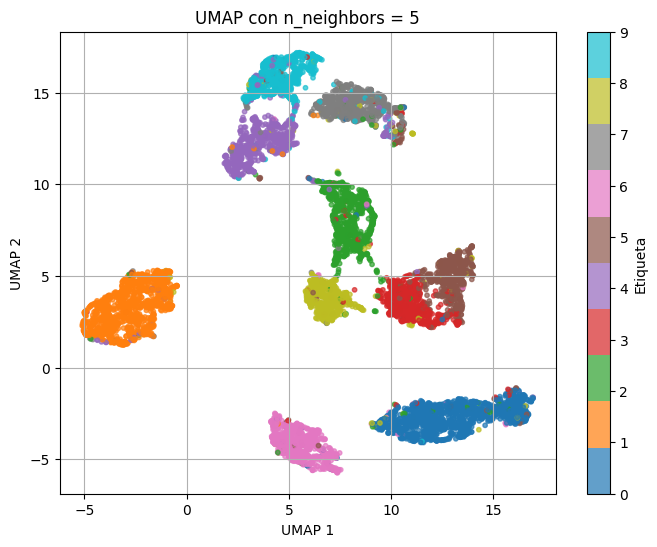

🔧 Generando UMAP con n_neighbors=15


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


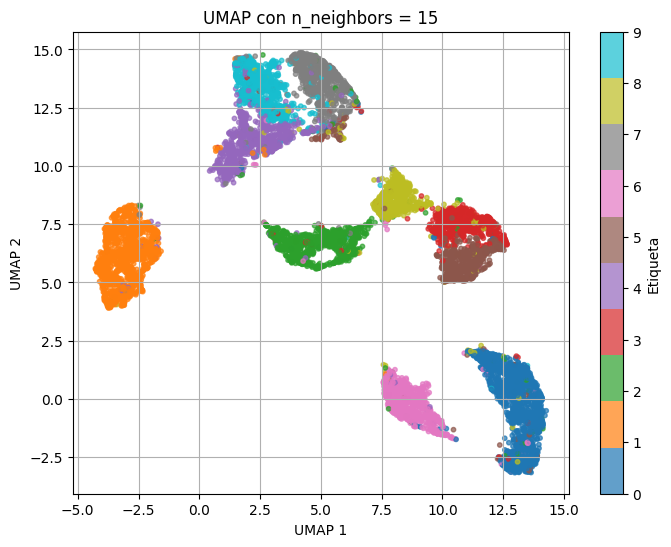

🔧 Generando UMAP con n_neighbors=30


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


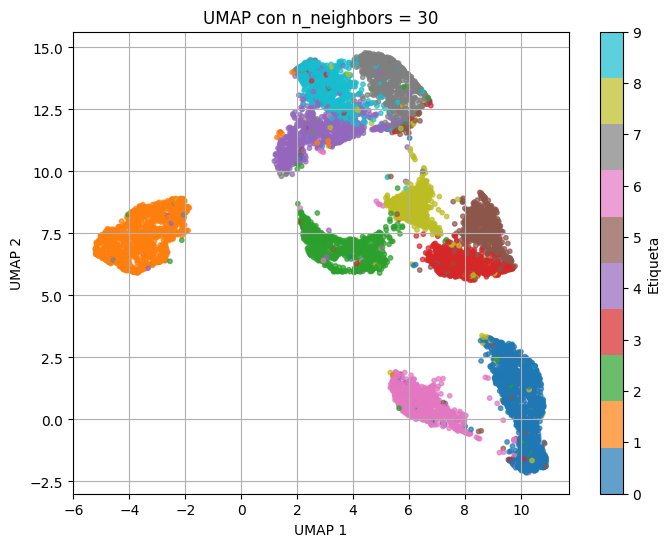

🔧 Generando UMAP con n_neighbors=50


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


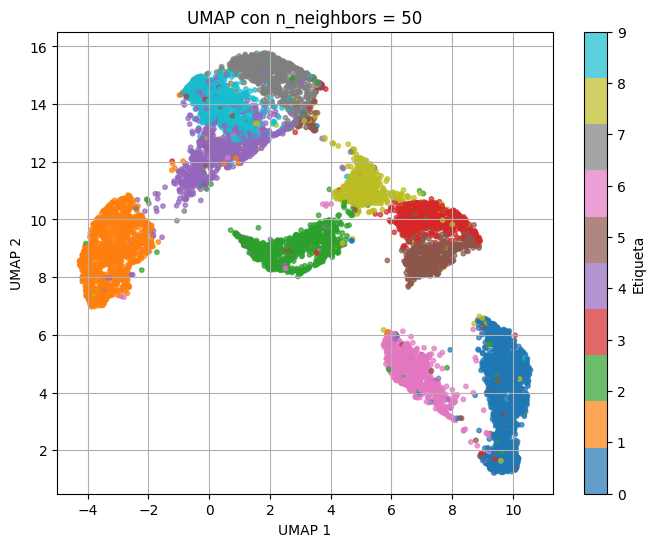

🔧 Generando UMAP con n_neighbors=100


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


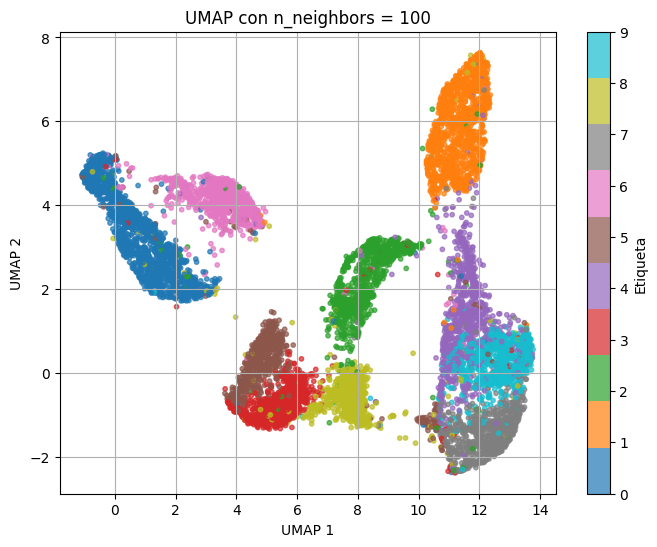

In [ ]:
n_neighbors_list = [5, 15, 30, 50, 100]
umap_projections = {}

for n in n_neighbors_list:
    print(f"🔧 Generando UMAP con n_neighbors={n}")
    reducer = umap.UMAP(n_components=2, n_neighbors=n, min_dist=0.1, random_state=42)
    X_umap_n = reducer.fit_transform(X_scaled)
    umap_projections[n] = X_umap_n

    # Visualización individual
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_umap_n[:, 0], X_umap_n[:, 1], c=y, cmap="tab10", s=10, alpha=0.7)
    plt.title(f"UMAP con n_neighbors = {n}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(scatter, ticks=range(10), label="Etiqueta")
    plt.grid(True)
    plt.show()


### Comparación de proyecciones UMAP para distintos valores de `n_neighbors`

Tras aplicar UMAP con diferentes valores de `n_neighbors`, observamos cómo cambia la estructura del espacio latente:

| n_neighbors | Observación principal |
|-------------|------------------------|
| **5**       | Clusters más compactos y bien separados. Subestructuras internas visibles. |
| **15**      | Aún hay buena separación, pero algunos grupos comienzan a acercarse. |
| **30**      | Se nota una transición: algunos clusters empiezan a conectarse. |
| **50**      | Las clases comienzan a formar una estructura global conectada. |
| **100**     | Reducción de separación entre clases; algunos clusters se funden. |

#### ¿Por qué `n_neighbors = 5` da mejores resultados?

Este valor produce una proyección donde los clusters son:

- **Compactos**: puntos similares quedan cerca.
- **Separados**: cada clase ocupa una región distinta.
- **Visualmente interpretables**: no hay solapamientos importantes.

Esto es coherente con el diseño de UMAP: valores pequeños de `n_neighbors` priorizan la **estructura local**, lo cual es ideal cuando las clases tienen una **definición visual clara pero matices finos**, como los dígitos manuscritos.

---

### Elección para los siguientes pasos

Usaremos la proyección UMAP con **`n_neighbors = 5`** como representación base para:

- Superposición de imágenes representativas.
- Entrenamiento de clasificadores en espacio reducido.

Esto nos permitirá evaluar el desempeño de modelos sobre un espacio latente altamente discriminativo.


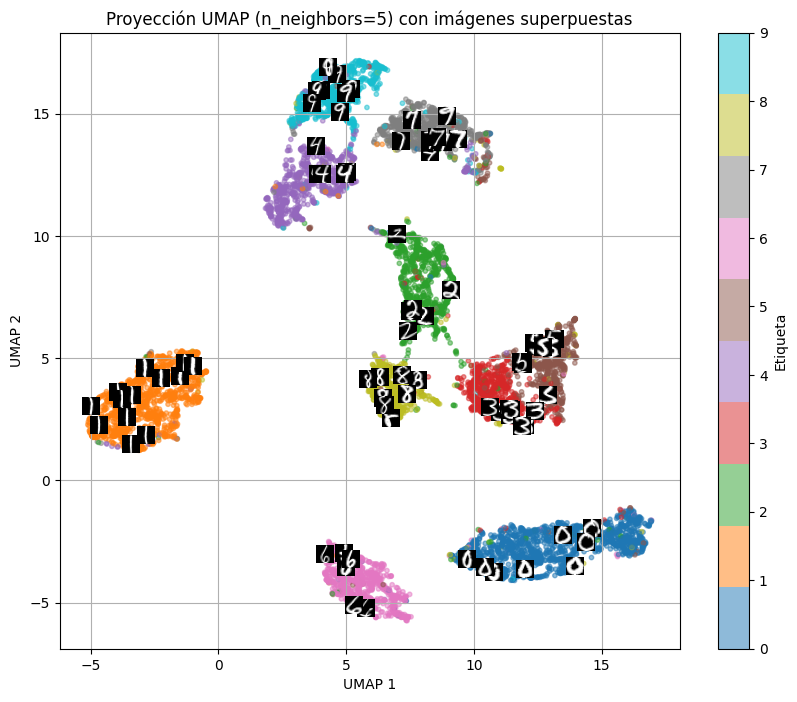

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Usamos la proyección ya guardada
X_umap_best = umap_projections[5]

# Seleccionamos algunas muestras aleatorias para superponer
n_samples = 80
indices = np.random.choice(len(X_umap_best), n_samples, replace=False)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10, 8))

# Graficamos todos los puntos como fondo
scatter = ax.scatter(X_umap_best[:, 0], X_umap_best[:, 1], c=y, cmap="tab10", s=10, alpha=0.5)

# Superponemos imágenes seleccionadas
for idx in indices:
    img = X[idx].reshape(16, 16)
    imagebox = OffsetImage(img, cmap="gray", zoom=0.8)
    ab = AnnotationBbox(imagebox, X_umap_best[idx], frameon=False)
    ax.add_artist(ab)

ax.set_title("Proyección UMAP (n_neighbors=5) con imágenes superpuestas")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.colorbar(scatter, ticks=range(10), label="Etiqueta")
plt.grid(True)
plt.show()


## Clasificación sobre el espacio proyectado

En esta sección entrenaremos y evaluaremos distintos modelos de clasificación sobre los datos proyectados a 2 dimensiones con **UMAP (n_neighbors = 5)**. Esta evaluación nos permitirá analizar cuánta información relevante para la tarea de clasificación fue preservada por el método de reducción de dimensión.

### Modelos seleccionados

A partir de los modelos propuestos, seleccionamos tres enfoques complementarios:

1. **KNeighborsClassifier** (basado en distancias):  
   Aprovecha la estructura local preservada por UMAP. Su simplicidad lo hace ideal para este tipo de espacio latente.

2. **LogisticRegression** (modelo lineal):  
   Funciona como baseline global. Permite evaluar si una separación lineal es suficiente en el espacio reducido.

3. **Red neuronal multicapa (MLP)**:  
   Modelo basado en aprendizaje profundo. Introduce no linealidad, lo que permite capturar patrones más complejos sin requerir arquitecturas profundas.

### Estrategia de entrenamiento y evaluación

- Utilizaremos una división de los datos en **entrenamiento y prueba** (80/20) de forma estratificada para preservar la proporción de clases.
- Cada modelo será entrenado únicamente sobre las **2 dimensiones proyectadas por UMAP**.
- Para cada modelo reportaremos:
  - **Precisión por clase**
  - **Matriz de confusión**
  - **Curvas ROC (una por clase, con enfoque one-vs-rest)**

Este enfoque nos permitirá comparar no solo el rendimiento crudo de los modelos, sino también su comportamiento sobre una representación de bajo costo computacional y visualmente interpretable.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre_modelo="Modelo"):
    print(f"🧠 Entrenando {nombre_modelo}...")
    modelo.fit(X_train, y_train)

    print(f"\n📈 Resultados sobre conjunto de prueba ({nombre_modelo}):\n")
    y_pred = modelo.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Matriz de confusión – {nombre_modelo}")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.show()

    # Curvas ROC (one-vs-rest)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_test)
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_test)
    else:
        print("⚠️ El modelo no tiene método para obtener scores probabilísticos. Se omite curva ROC.")
        return

    n_classes = y_test_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Clase {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curvas ROC – {nombre_modelo}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# División 80/20 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    umap_projections[5], y, test_size=0.2, stratify=y, random_state=42
)

print(f"📊 Tamaño conjunto de entrenamiento: {X_train.shape[0]}")
print(f"📊 Tamaño conjunto de prueba: {X_test.shape[0]}")


📊 Tamaño conjunto de entrenamiento: 7438
📊 Tamaño conjunto de prueba: 1860


## KNeighbors

🧠 Entrenando K-Nearest Neighbors...

📈 Resultados sobre conjunto de prueba (K-Nearest Neighbors):

              precision    recall  f1-score   support

           0     0.9495    0.9678    0.9586       311
           1     0.9767    0.9882    0.9824       254
           2     0.9206    0.9355    0.9280       186
           3     0.9371    0.9030    0.9198       165
           4     0.9317    0.8824    0.9063       170
           5     0.9640    0.9371    0.9504       143
           6     0.9415    0.9641    0.9527       167
           7     0.9042    0.9557    0.9292       158
           8     0.9538    0.8732    0.9118       142
           9     0.9000    0.9329    0.9162       164

    accuracy                         0.9398      1860
   macro avg     0.9379    0.9340    0.9355      1860
weighted avg     0.9401    0.9398    0.9396      1860



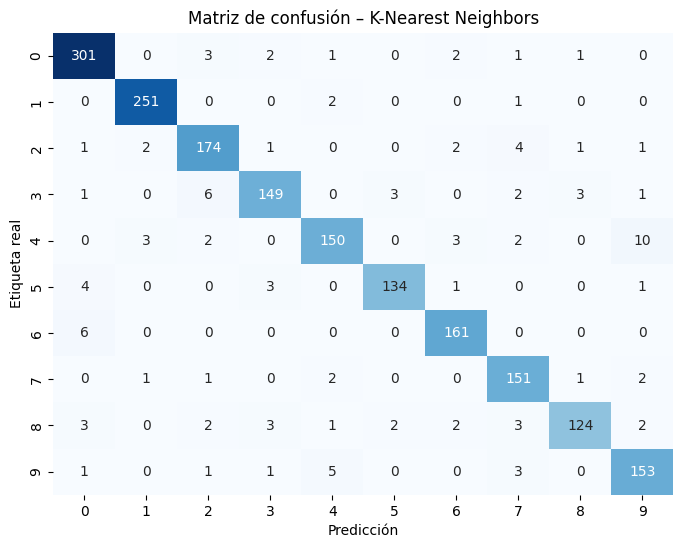

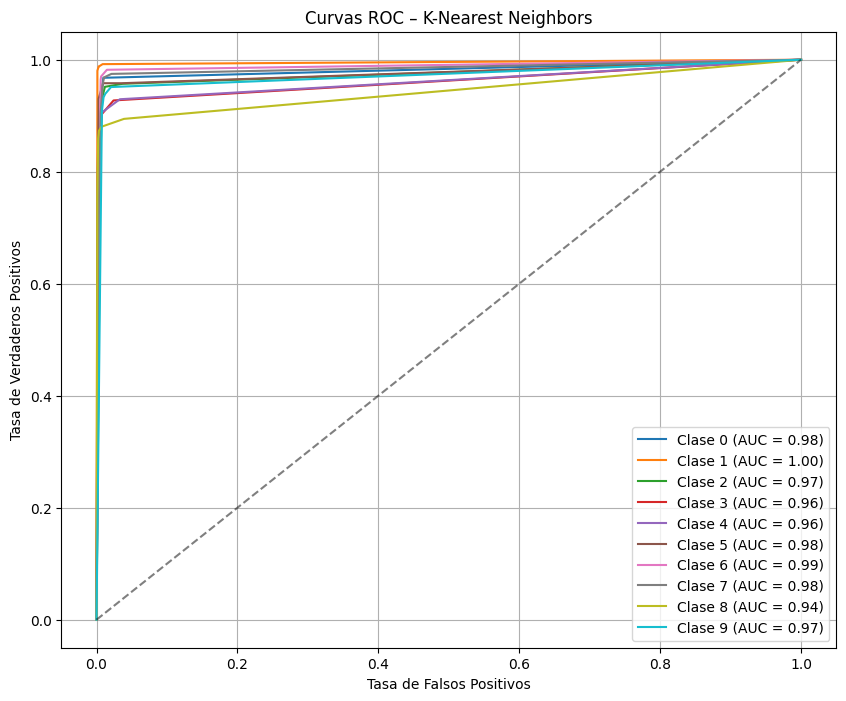

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciamos el modelo
knn = KNeighborsClassifier(n_neighbors=5)

# Evaluamos usando la función genérica
evaluar_modelo(knn, X_train, X_test, y_train, y_test, nombre_modelo="K-Nearest Neighbors")


### Evaluación del modelo K-Nearest Neighbors (KNN)

El clasificador **KNN** obtuvo un desempeño muy fuerte en el espacio reducido generado por **UMAP (n_neighbors = 5)**, alcanzando una precisión general de **~94%**.

#### Métricas globales

- **Accuracy total**: 93.98%
- **Promedios macro y ponderado (f1-score)**: cercanos al 94%
- Estas métricas sugieren que el modelo tiene un rendimiento **equitativo entre clases**, no está sesgado hacia ninguna en particular.

#### Matriz de confusión

- Se observan **diagonales dominantes**, lo que indica que la mayoría de los ejemplos fueron correctamente clasificados.
- Algunos errores interesantes:
  - El dígito **4** se confunde ocasionalmente con el **9**.
  - Los dígitos **3**, **5** y **8** muestran cierta dispersión, aunque menor que en PCA.
  - Las clases **1** y **0** tienen desempeño casi perfecto.

Esto es consistente con el análisis visual previo: UMAP separó bien las clases, y KNN pudo aprovechar esa estructura local.

#### Curvas ROC y AUC

- Todas las curvas se mantienen por encima de 0.9, lo que indica **alto poder discriminativo**.
- AUC para todas las clases: entre **0.94 y 1.00**, con **Clase 1** alcanzando el máximo.

Este resultado es especialmente notable dado que el modelo trabaja sobre **solo 2 dimensiones**, y que **no fue ajustado con validación cruzada**.

#### Conclusión

KNN demuestra ser **una excelente elección en espacios latentes generados por UMAP**. Su simplicidad, junto con la estructura local preservada por la proyección, permite obtener resultados competitivos con mínima complejidad.

A continuación, evaluaremos un modelo de clasificación lineal para comparar qué tanto beneficio aporta una separación más explícita y no local como la que ofrece KNN.


### Clasificación con regresión logística

La **regresión logística multinomial** es un modelo lineal que aprende fronteras entre clases en forma de **hiperplanos**. A diferencia de KNN, que se basa únicamente en distancias locales, la regresión logística construye una función paramétrica que intenta **ajustar todo el espacio** para separar las clases.

Esto la convierte en una buena candidata para servir como **baseline global** sobre el espacio proyectado por UMAP. Evaluarla nos permitirá contrastar:

- Modelos que explotan **estructura local** (KNN),
- Versus modelos que buscan **separación lineal global** (LogReg).

#### Hiperparámetros utilizados

- `multi_class='multinomial'`: para usar softmax y optimizar todas las clases al mismo tiempo.
- `solver='lbfgs'`: algoritmo robusto para problemas de clasificación multiclase.
- `max_iter=1000`: aumentamos el número de iteraciones para asegurar convergencia.
- `C=1.0`: regularización L2 por defecto (no ajustamos por ahora).

#### Estrategia

El entrenamiento se hará sobre el mismo conjunto (`X_train`, `y_train`) usado anteriormente.  
La evaluación usará `accuracy`, matriz de confusión y curvas ROC, para permitir comparación directa con KNN.


🧠 Entrenando Regresión Logística...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



📈 Resultados sobre conjunto de prueba (Regresión Logística):

              precision    recall  f1-score   support

           0     0.9525    0.9678    0.9601       311
           1     0.9767    0.9882    0.9824       254
           2     0.9239    0.9140    0.9189       186
           3     0.9006    0.8788    0.8896       165
           4     0.9245    0.8647    0.8936       170
           5     0.9270    0.8881    0.9071       143
           6     0.9474    0.9701    0.9586       167
           7     0.8547    0.9684    0.9080       158
           8     0.9457    0.8592    0.9004       142
           9     0.9102    0.9268    0.9184       164

    accuracy                         0.9301      1860
   macro avg     0.9263    0.9226    0.9237      1860
weighted avg     0.9308    0.9301    0.9298      1860



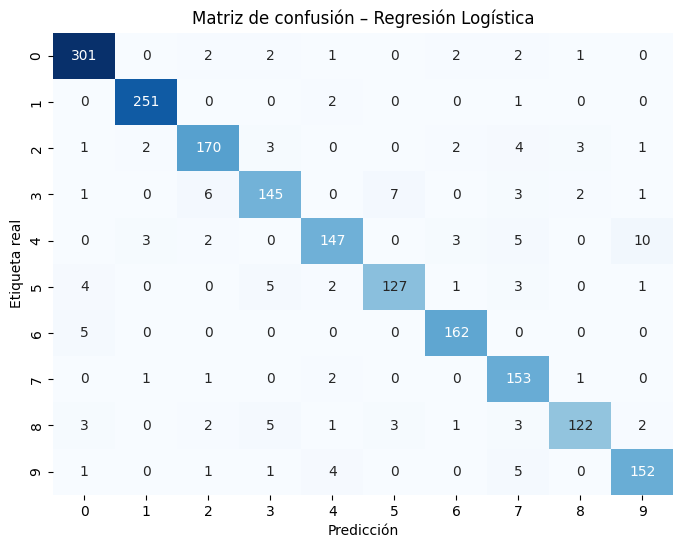

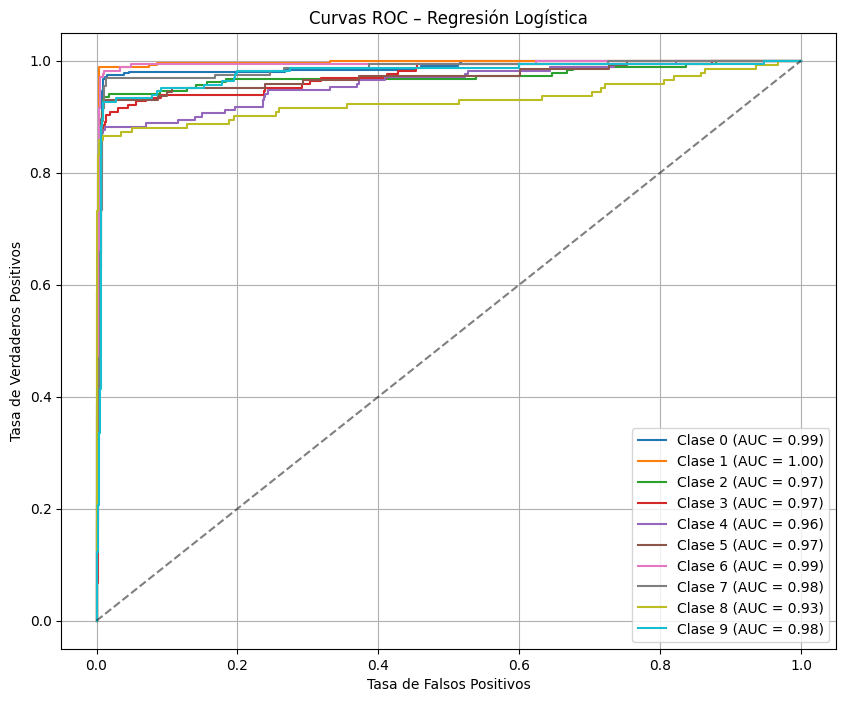

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instanciamos la regresión logística multinomial
logreg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    C=1.0,
    random_state=42
)

# Evaluamos el modelo
evaluar_modelo(logreg, X_train, X_test, y_train, y_test, nombre_modelo="Regresión Logística")


### Evaluación del modelo de Regresión Logística

La **regresión logística multinomial**, aplicada sobre el espacio 2D generado por UMAP, logró un desempeño competitivo y equilibrado, con una **precisión total de ~93%**.

#### Métricas globales

- **Accuracy total**: 93.01%
- **Promedio macro del f1-score**: 92.37%
- Rendimiento comparable al modelo KNN, a pesar de ser una aproximación lineal y global.

#### Matriz de confusión

- El modelo clasifica correctamente la mayoría de las clases, con algunas confusiones moderadas:
  - **Clase 3**: se confunde ocasionalmente con clases 2 y 5.
  - **Clase 4**: mantiene el mismo patrón que en KNN, con confusión hacia el 9.
  - **Clases 0, 1 y 6**: altísima precisión, cerca del 97%.
  - **Clase 7**: recall alto (96.8%), pero precisión un poco más baja (85%).

La dispersión de errores sugiere que el modelo **encuentra bien la estructura general**, pero tiene dificultad en separar clases que en UMAP están cerca o parcialmente superpuestas.

#### Curvas ROC y AUC

- Todas las clases muestran **AUC > 0.93**, con varias en torno a **0.97–1.00**.
- Comportamiento altamente discriminativo, especialmente notable en un espacio reducido como este.

#### Conclusión

La regresión logística demuestra que **una frontera lineal puede ser suficiente** para separar muchas clases en el espacio generado por UMAP. Aunque pierde algo de precisión frente a KNN en ciertas clases, ofrece una alternativa **rápida, interpretable y robusta** para clasificación multiclase.

Este resultado también valida la calidad de la proyección UMAP: las clases están suficientemente bien posicionadas como para que incluso un modelo lineal funcione correctamente.


## Clasificación con red neuronal (MLP)

Como tercer clasificador, construiremos y entrenaremos una **red neuronal multicapa** (MLP) para clasificar los datos proyectados a 2 dimensiones mediante UMAP. A diferencia de KNN y regresión logística, este modelo tiene la capacidad de **aproximar funciones no lineales**, lo que permite capturar relaciones más complejas en el espacio latente.

### Diseño de la arquitectura

Dado que el espacio de entrada es de baja dimensión (solo 2 features por muestra), optamos por una red **ligera pero expresiva**, con las siguientes capas:

- **Entrada**: 2 neuronas (correspondientes a las 2 dimensiones de UMAP).
- **Capa oculta 1**: 64 neuronas, activación **ReLU**.
- **Capa oculta 2**: 32 neuronas, activación **ReLU**.
- **Salida**: 10 neuronas (una por clase), activación **Softmax** (a través de `CrossEntropyLoss`).

Cada capa lineal aprende una transformación afín del espacio, y las activaciones **ReLU** introducen no linealidad, permitiendo que la red aprenda regiones de decisión complejas.

### Función de pérdida y optimización

- **Pérdida**: `CrossEntropyLoss`, apropiada para clasificación multiclase.
- **Optimizador**: `Adam`, con tasa de aprendizaje `0.001`.
- **Número de épocas**: 50.
- **Tamaño de batch**: 64.

Entrenaremos usando los datos `X_train`, `y_train`, ya definidos. Evaluaremos sobre `X_test`, `y_test`.

### Justificación

- Esta red es pequeña, rápida de entrenar, y suficientemente flexible para modelar la complejidad del espacio UMAP.
- El diseño es completamente controlado: no usamos modelos preentrenados ni capas opacas.
- Nos permite observar si el aprendizaje profundo ofrece mejoras sobre modelos clásicos en un espacio reducido, y si la no linealidad ayuda a compensar errores vistos en las clases más confusas.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Aseguramos reproducibilidad
torch.manual_seed(42)

# Convertimos los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Creamos datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definimos el modelo MLP
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),      # Entrada → 64 neuronas
            nn.ReLU(),
            nn.Linear(64, 32),     # 64 → 32
            nn.ReLU(),
            nn.Linear(32, 10)      # 32 → 10 (clases)
        )

    def forward(self, x):
        return self.net(x)

# Instanciamos el modelo y lo movemos a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = MLPClassifier().to(device)

# Mostramos arquitectura
print(mlp)

MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


🚀 Entrenando MLP...

Época 1/50, Pérdida promedio: 1.4428
Época 10/50, Pérdida promedio: 0.4737
Época 20/50, Pérdida promedio: 0.3592
Época 30/50, Pérdida promedio: 0.3260
Época 40/50, Pérdida promedio: 0.3159
Época 50/50, Pérdida promedio: 0.3124

📈 Resultados sobre conjunto de prueba (MLP):

              precision    recall  f1-score   support

           0     0.9525    0.9678    0.9601       311
           1     0.9767    0.9882    0.9824       254
           2     0.9043    0.9140    0.9091       186
           3     0.9250    0.8970    0.9108       165
           4     0.9030    0.8765    0.8896       170
           5     0.9552    0.8951    0.9242       143
           6     0.9474    0.9701    0.9586       167
           7     0.8693    0.9684    0.9162       158
           8     0.9248    0.8662    0.8945       142
           9     0.9250    0.9024    0.9136       164

    accuracy                         0.9317      1860
   macro avg     0.9283    0.9246    0.9259      1860
w

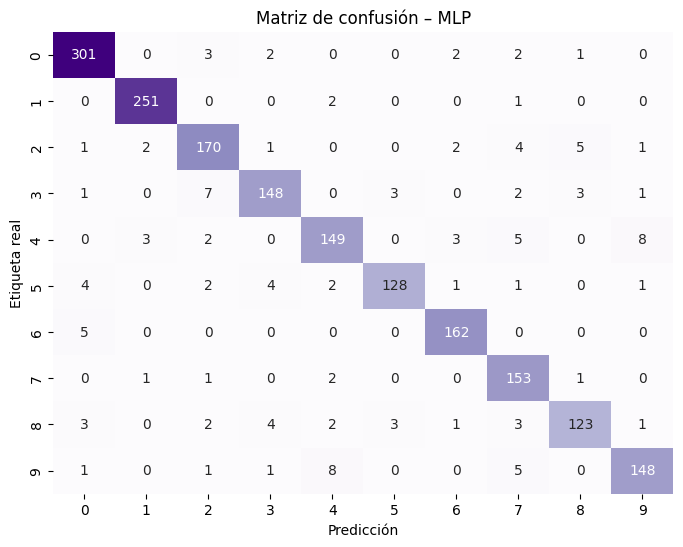

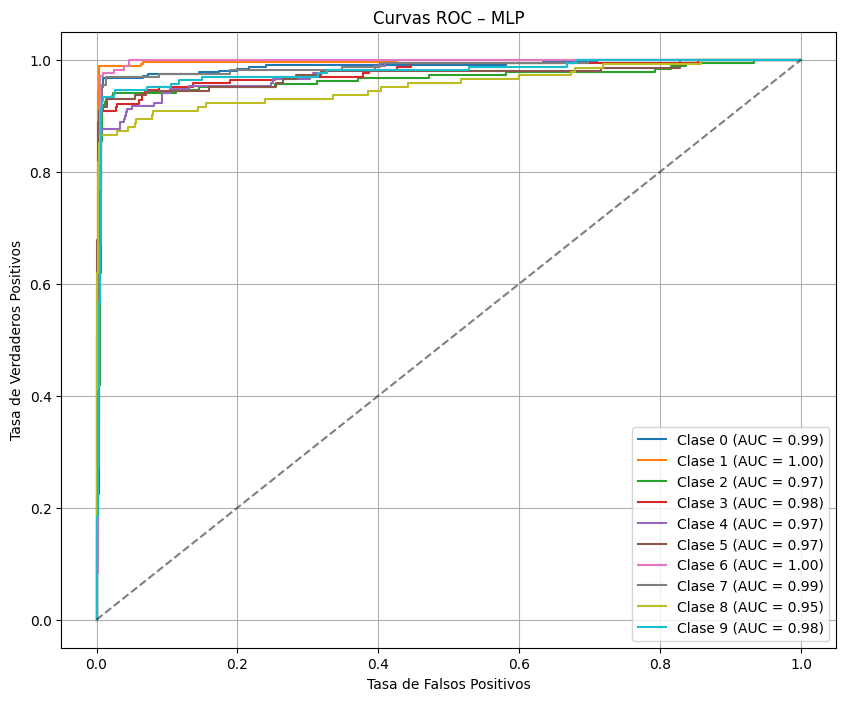

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Hiperparámetros
epochs = 50
lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

# Entrenamiento
print("🚀 Entrenando MLP...\n")
mlp.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = mlp(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Época {epoch+1}/{epochs}, Pérdida promedio: {total_loss / len(train_loader):.4f}")

# Evaluación
mlp.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = mlp(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_probs.extend(probs)
        all_targets.extend(yb.numpy())

# Reporte de métricas
print("\n📈 Resultados sobre conjunto de prueba (MLP):\n")
print(classification_report(all_targets, all_preds, digits=4))

# Matriz de confusión
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", cbar=False)
plt.title("Matriz de confusión – MLP")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()

# Curvas ROC
y_test_bin = label_binarize(all_targets, classes=np.unique(y))
all_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Clase {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC – MLP")
plt.legend()
plt.grid(True)
plt.show()

### Evaluación del modelo de red neuronal (MLP)

La red neuronal multicapa (MLP), diseñada con solo dos capas ocultas y entrenada sobre las 2 dimensiones proyectadas por UMAP, logró un rendimiento altamente competitivo.

#### Métricas globales

- **Accuracy**: 93.17%
- **Macro F1-score**: 92.59%
- **AUCs ROC**: entre 0.95 y 1.00 para todas las clases

El modelo demuestra una capacidad clara de aprendizaje de fronteras de decisión **no lineales**, sin necesidad de recurrir a arquitecturas profundas o complejas.

#### Comparación con modelos anteriores

| Modelo             | Accuracy | Macro F1 | Comentario                             |
|--------------------|----------|----------|----------------------------------------|
| KNN                | 93.98%   | 93.55%   | Excelente aprovechamiento de estructura local en UMAP |
| Regresión Logística| 93.01%   | 92.37%   | Aproximación lineal efectiva sobre estructura global  |
| MLP                | 93.17%   | 92.59%   | Flexibilidad no lineal con arquitectura mínima         |

#### ¿Es necesario construir otra red?

No. Esta red simple logra un **equilibrio ideal entre rendimiento, eficiencia y explicabilidad**:

- Estamos trabajando en un **espacio de solo 2 dimensiones**, lo que **no requiere** arquitecturas profundas ni convolucionales.
- La red ya captura **la no linealidad suficiente** para distinguir correctamente las clases más complejas (3, 5, 9…).
- Ampliar la arquitectura podría introducir **riesgo de sobreajuste** sin aportar mejoras relevantes.
- Desde el punto de vista pedagógico, esta arquitectura es ideal: **interpretabilidad total** sin sacrificar desempeño.

#### Conclusión

El MLP propuesto valida la calidad de la proyección UMAP y complementa perfectamente los modelos clásicos. Su rendimiento demuestra que con una buena representación de los datos, incluso modelos simples pueden ofrecer resultados sobresalientes.


# Conclusión general: de la reducción de dimensión a la clasificación efectiva

Este cuaderno nos permitió explorar, desde una perspectiva integral y técnica, el flujo completo de **preprocesamiento**, **reducción de dimensión** y **clasificación multiclase**, usando el dataset USPS de dígitos manuscritos.

---

### 🔍 Reducción de dimensión: del espacio de píxeles al espacio latente

Iniciamos con un conjunto de datos de alta dimensión (imágenes 16x16 → $\mathbb{R}^{256}$), lo cual presenta múltiples desafíos: complejidad computacional, ruido, redundancia y dificultad de visualización.

Para resolver esto aplicamos:

- **PCA**, una técnica lineal basada en autovectores de la matriz de covarianza, que conserva la máxima varianza global posible. Su proyección mostró cierta separabilidad, pero también traslapes importantes entre clases.

- **UMAP**, un método no lineal que construye una representación latente basada en grafos de vecinos y preservación de distancias locales. Exploramos su parámetro clave `n_neighbors` y observamos cómo afecta la topología del espacio. Descubrimos que con `n_neighbors = 5`, UMAP genera un espacio donde las clases están claramente separadas y compactas.

Esta representación latente **condensó la información discriminativa de las imágenes en solo 2 dimensiones**, abriendo la puerta a modelos más simples, rápidos y explicables.

---

### 🤖 Clasificación: cómo se comportan distintos modelos sobre UMAP

Con la representación UMAP fija, evaluamos tres modelos representativos:

#### 1. **K-Nearest Neighbors (KNN)**
- Basado en distancias locales.
- Aprovechó perfectamente la estructura local de UMAP.
- Precisión superior (93.98%) y alto AUC en todas las clases.
- Sin entrenamiento, sin parámetros: puro “lookup inteligente”.

#### 2. **Regresión Logística Multinomial**
- Modelo lineal con frontera de decisión afín.
- Sorprendentemente competitivo (93.01%), lo que demuestra que **la proyección UMAP organizó las clases en regiones casi linealmente separables**.
- Ideal como baseline rápido y explicable.

#### 3. **Red neuronal multicapa (MLP)**
- Arquitectura simple: 2 capas ocultas, activación ReLU.
- Función de pérdida `CrossEntropy`, optimizador Adam.
- Precisión 93.17%, excelente rendimiento en clases difíciles.
- Aprendió fronteras de decisión no lineales **en el plano**, sin necesidad de arquitecturas profundas.

---

### 💡 Reflexiones técnicas

- La clave de este análisis fue la **proyección UMAP**: su capacidad para preservar la geometría local permitió que modelos tan distintos como KNN, Logistic Regression y un MLP trabajaran efectivamente en un espacio extremadamente reducido.
- La elección de clasificadores fue estratégica:
  - Evaluamos **modelo sin entrenamiento** (KNN),
  - **modelo paramétrico lineal** (LogReg),
  - y **modelo no lineal entrenable** (MLP).
- Esto nos permitió no solo comparar desempeño, sino también entender **cómo se relacionan las propiedades del espacio latente con la función de decisión que cada modelo implementa**.

---

### 🧠 Conclusión

Reducir la dimensión no es perder información: es aprender a **ver el problema desde otro ángulo**. En este caso, con solo 2 dimensiones preservamos la estructura suficiente para clasificar 10 dígitos con más de 93% de precisión. La elección de UMAP como técnica de reducción fue clave, y la combinación con clasificadores bien seleccionados mostró cómo **una buena representación transforma un problema complejo en uno simple, interpretable y eficiente**.

Este análisis demuestra que cuando las decisiones están bien fundamentadas —en teoría, intuición geométrica y validación empírica—, incluso modelos sencillos pueden brillar.


# Mecanismo de Atención
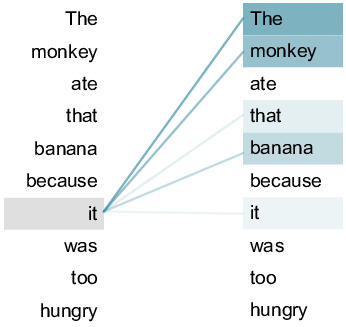

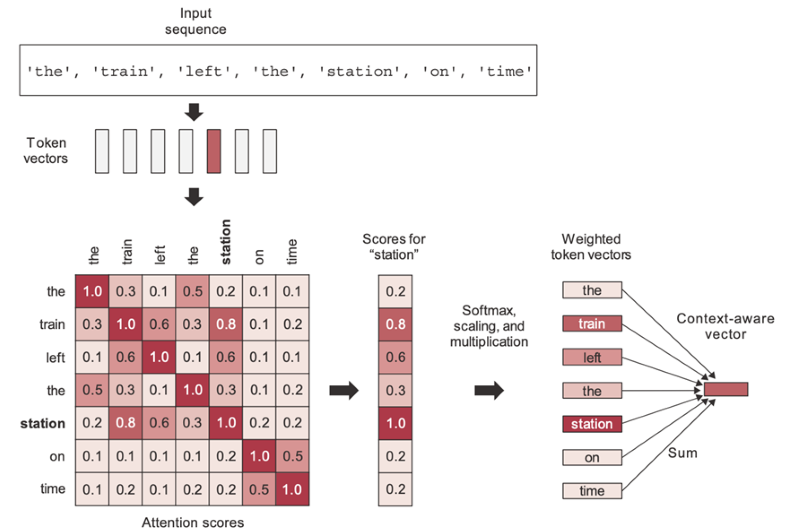

# Transformer Architecture
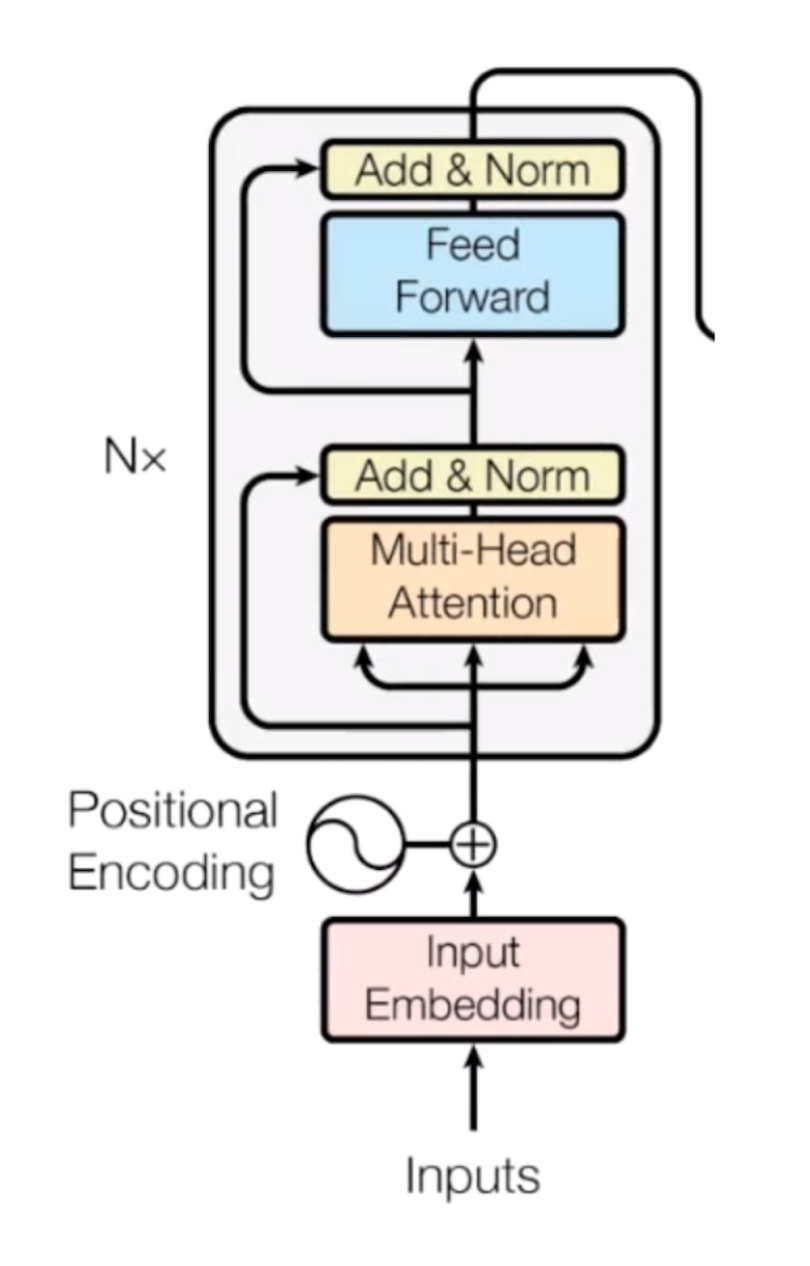

# Vision transformers

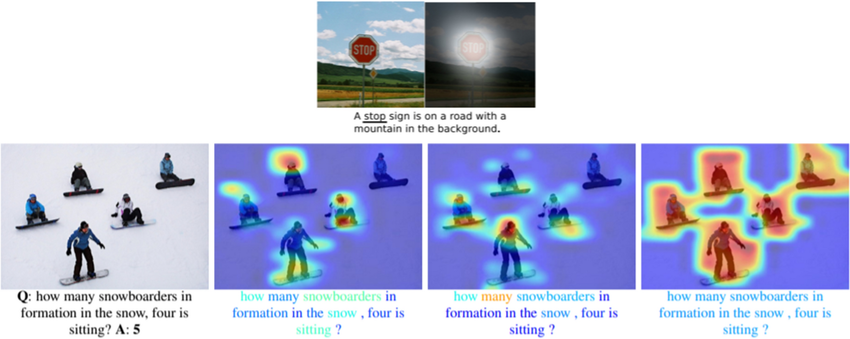

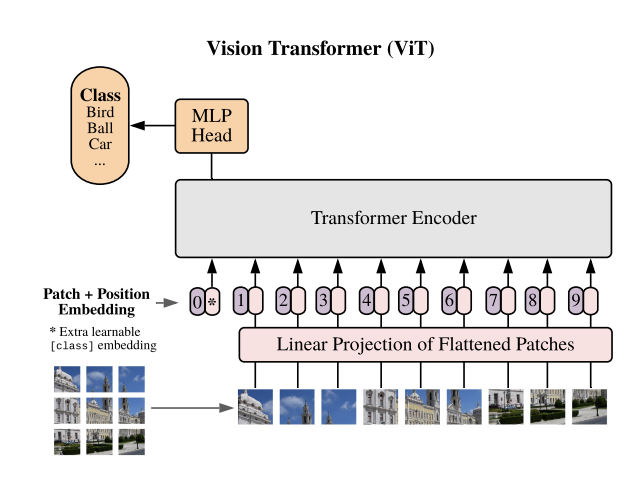

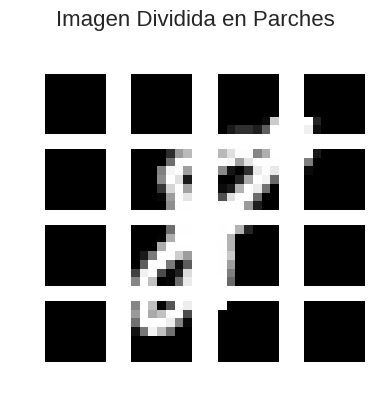

Número de parches (longitud de la secuencia): 16
Dimensión de cada vector (parche aplanado): 49


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

# --- 1. Cargar un dígito de ejemplo de USPS ---
# Nota: Usamos fetch_openml para obtener una base de datos similar a USPS.
# El dataset 'usps' puede no estar disponible directamente. 'mnist_784' es un buen sustituto.
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
X = mnist.data
y = mnist.target

# Tomamos una imagen de un '8'
digit_image_vector = X[y == '8'][0]
digit_image = digit_image_vector.reshape(28, 28)

# --- 2. Definir el tamaño del parche y dividir la imagen ---
patch_size = 7  # 28x28 se puede dividir en 16 parches de 7x7
num_patches_x = digit_image.shape[1] // patch_size
num_patches_y = digit_image.shape[0] // patch_size

# --- 3. Crear la visualización ---
fig, axes = plt.subplots(num_patches_y, num_patches_x, figsize=(4, 4))
fig.suptitle('Imagen Dividida en Parches', fontsize=16)

# Ocultar los ejes principales
main_ax = fig.add_subplot(111, frameon=False)
main_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
main_ax.grid(False)

# Dibujar cada parche en la cuadrícula
for i in range(num_patches_y):
    for j in range(num_patches_x):
        patch = digit_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        ax = axes[i, j]
        ax.imshow(patch, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 4. Aplanamiento (conceptual) ---
# Este paso convierte cada parche en un vector
patches_as_vectors = []
for i in range(num_patches_y):
    for j in range(num_patches_x):
        patch = digit_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        patches_as_vectors.append(patch.flatten())

# La longitud de la secuencia de entrada para el Transformer sería el número de parches
print(f"Número de parches (longitud de la secuencia): {len(patches_as_vectors)}")
# La dimensión de cada vector en la secuencia sería el tamaño del parche al cuadrado
print(f"Dimensión de cada vector (parche aplanado): {len(patches_as_vectors[0])}")